In [21]:
import pickle as pkl
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pytrec_eval
import ir_datasets
from collections import defaultdict
import json
import scipy
from scipy.stats import pearsonr
import torch
%matplotlib inline

In [16]:
def read_rep(model, dataset, is_logvar=False):
    with open(os.path.join("rep", model, dataset + ".pkl") , "rb") as reader:
        mean, var, ids = pkl.load(reader)
        if is_logvar:
            var = np.exp(var)

        return mean, var, ids


TASB_LV = "mvrl_nd_tasb_logvar"
DB = "mvrl_nd_db"

In [26]:
def sample_standard(d, n):
    mean = np.zeros(d)
    cov = np.diag(np.ones(d))
    dist = scipy.stats.multivariate_normal(mean=mean, cov=cov)
    means = dist.rvs(size=n)
    return means, np.ones_like(means)


## Plotting the norms of the mean & variances vectors 

We experiment with two models:
- mvrl_nd_db = DistilBERT init, no distillation, softplus, which has very poor performance when only the mean is used
- mvrl_nd_tasb_logvar = TASB init, no distillation, logvar, which has fair (but still relatively poor) performance when only the mean vectors are used in retrieval



We experiment with 2 datasets:

- msmarco-dev -- Documents/Queries from the MSMARCO dev set
- dev_scifact -- Documents/Queries from scifact test set


In [6]:
# plot the norms of the means/variances
def plot_norms(models, is_lv, datasets, bins=10, norm_ord=2):

    fig, ax = plt.subplots(nrows=2, figsize=(10, 10))

    for model, lv in zip(models, is_lv):
        for dataset in datasets:
            mean, var, _ = read_rep(model, dataset, is_logvar=lv)

            ax[0].hist(np.linalg.norm(mean, axis=1, ord=norm_ord), bins=bins, label=f"{model} ({dataset})", density=True, alpha=0.6)
            ax[1].hist(np.linalg.norm(var, axis=1, ord=norm_ord), bins=bins, label=f"{model} ({dataset})", density=True, alpha=0.6)

    ax[0].set_title("mean")
    ax[0].legend()
    ax[1].set_title("var")
    ax[1].legend()
        


**Plot the norm of the queries** 

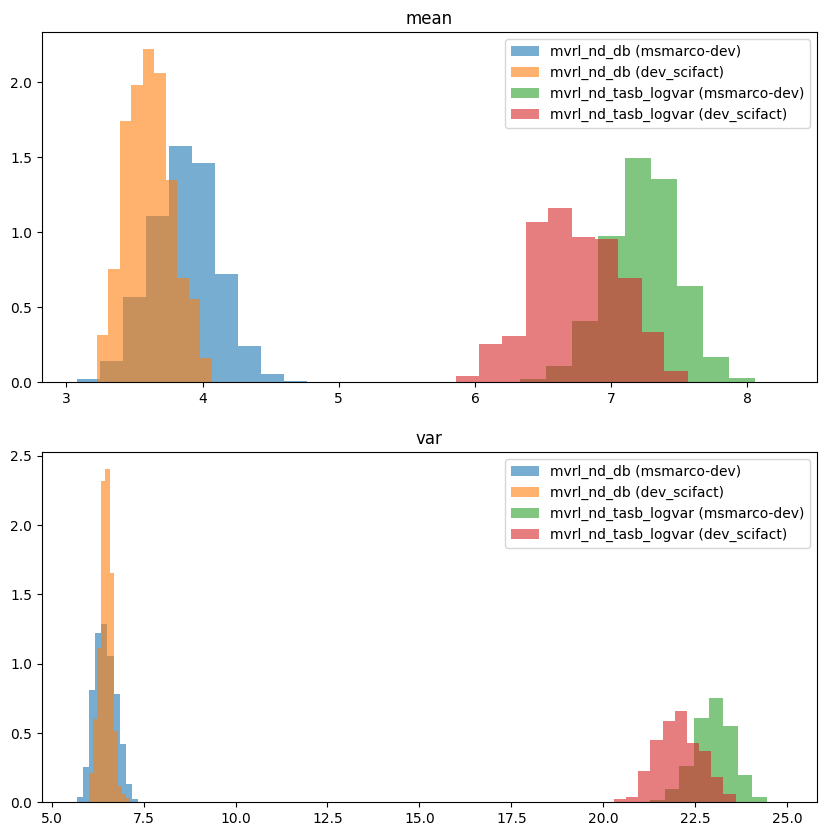

In [24]:
plot_norms((DB, TASB_LV), (False, True), ("msmarco-dev", "dev_scifact"))

**Plot the norms of the documents**

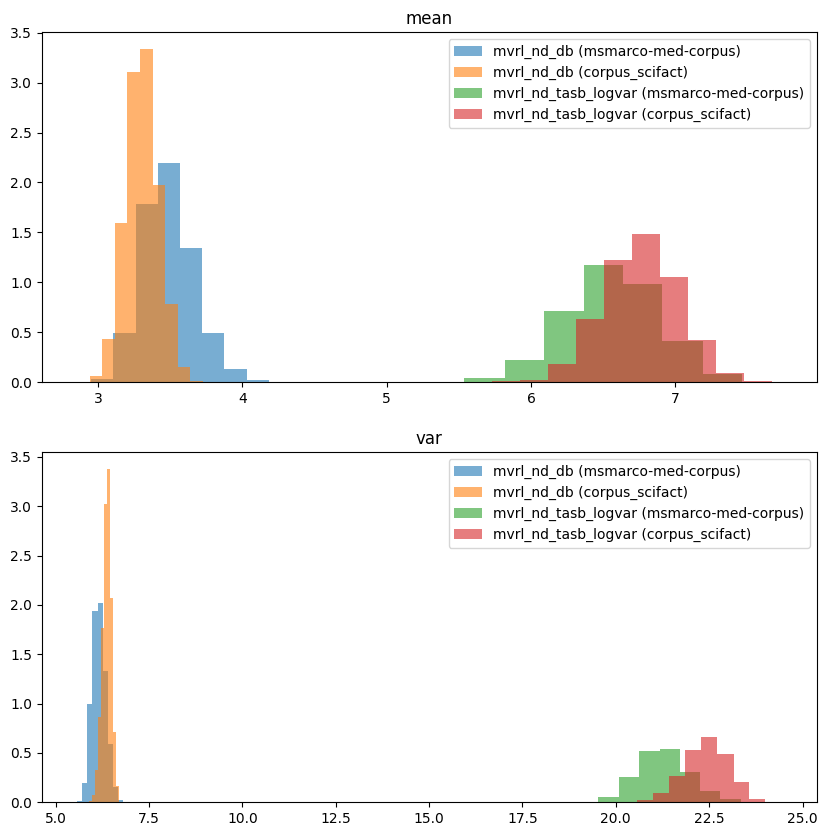

In [9]:
plot_norms((DB, TASB_LV), (False, True), ("msmarco-med-corpus", "corpus_scifact"))

**Observations:**
- The norms for the variance is much smaller for DB compared to the TASBLV model.
- The distributions of var-norms for the datasets are well separated for the TASB model, but not as well for the DB model.
- The distribution for the OOD dataset is peakier, when the opposite should be true -- the variances should be larger for the unknown dataset

## TSNE plots



**The alpha is proportional to the variance** -- the higher it is, the more transparent it is represented in the plot below

In [36]:
def normalize_minmax(v):
    return (v - v.min()) / (v.max() - v.min())

def tsne_plots(models, is_lv, datasets, sample=None, norm_ord=2, var_alpha=True):

    fig, ax = plt.subplots(nrows=len(models), figsize=(10, len(models)*7))
    for plt_idx, (model, lv) in enumerate(zip(models, is_lv)):
        for dataset_idx, dataset in enumerate(datasets):
            mean, var, _ = read_rep(model, dataset, is_logvar=lv)
            if sample:
                n_ = sample[dataset_idx] if isinstance(sample, list) else sample
                _ = np.random.permutation(np.arange(len(mean)))[:n_]
                mean = mean[_]
                var = var[_]
            
            # mean TSNE
            X = TSNE().fit_transform(mean)
            # alpha of the datapoints are based on the variance
            if var_alpha:
                var_norm = np.linalg.norm(var, axis=1, ord=norm_ord)
                # after normalization, do 1 - norm, so that higher unccertainty data gets low alpha values
                var_norm = 1-normalize_minmax(var_norm)
                ax[plt_idx].scatter(X[:, 0], X[:, 1], label=dataset, alpha=var_norm, edgecolors='red', linewidth=0.5)
            else:
                ax[plt_idx].scatter(X[:, 0], X[:, 1], label=dataset, alpha=0.3, edgecolors='red')
            
        ax[plt_idx].legend()
        if sample:
            ax[plt_idx].set_title(model + f"({sample} samples)")
        else:
            ax[plt_idx].set_title(model)

                      


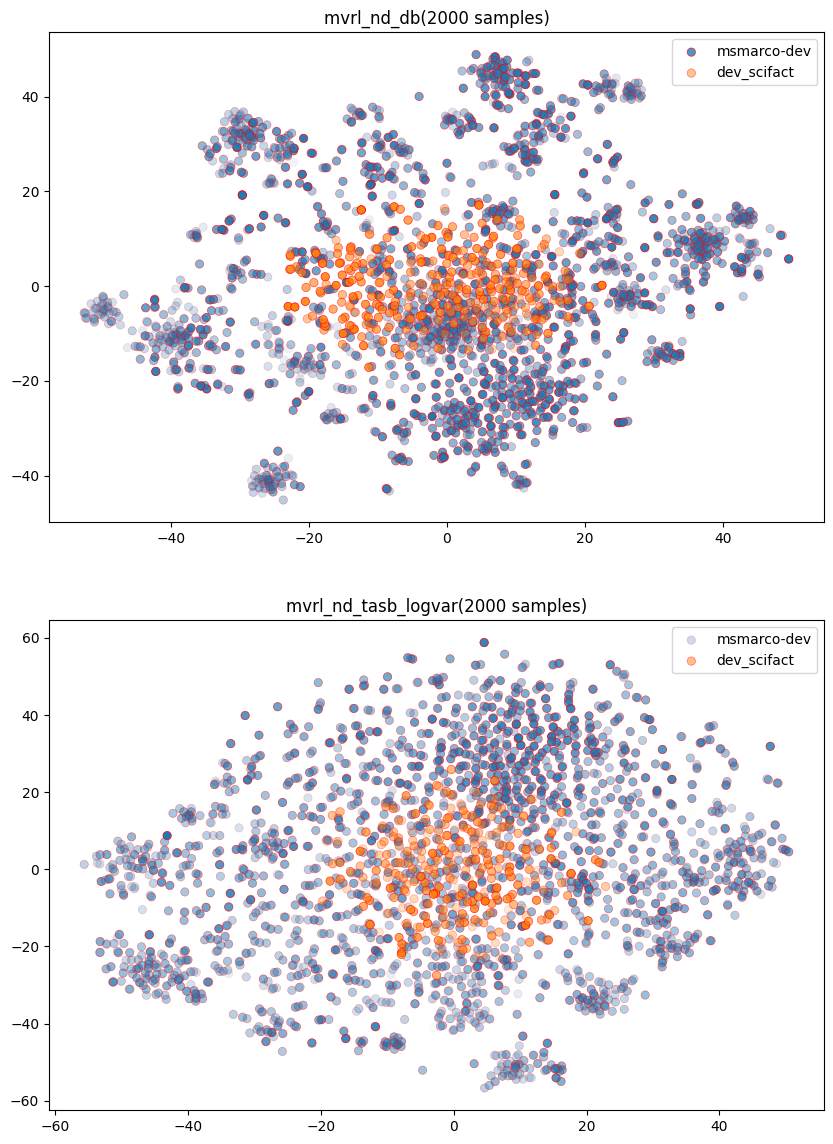

In [37]:
tsne_plots((DB, TASB_LV), (False, True), ("msmarco-dev", "dev_scifact"), sample=2000)  

- The DB model seems to have several queries clustered together. Queries outside this cluster seems to be assigned low probabilities. 
- The TASB model has more 'spread out' clusters, with similar behaviour -- if it is far from the central cluster, it is assigned a higher variance. There 'variance of the variance' seems to be higher, but it's perhaps an artifact of how we're plotting. 

### Corpus docs

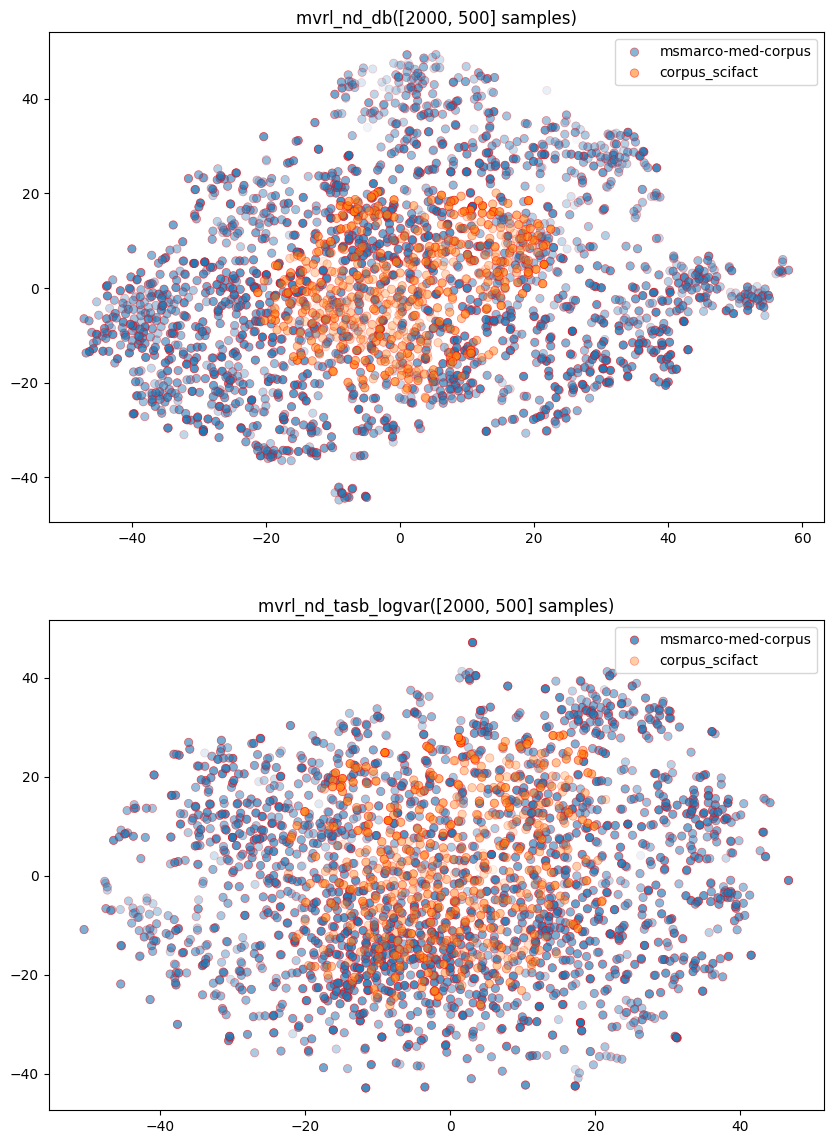

In [38]:
tsne_plots((DB, TASB_LV), (False, True), ("msmarco-med-corpus", "corpus_scifact"), sample=[2000, 500])

In [7]:
# what is the Mean <> Mean distance compared to the LV distances? 
def evaluate(run, irds_name, metric):
    d = ir_datasets.load(irds_name)
    qrels = defaultdict(dict)
    for qrel in d.qrels_iter():
        qrels[qrel.query_id][qrel.doc_id] = qrel.relevance

    res = pytrec_eval.RelevanceEvaluator(qrels, [metric]).evaluate(run)
    vals = []
    for qid, mets in res.items():
        vals.append(mets[metric])
        
    return np.mean(vals), res

def get_run(q_rep, qids, d_rep, dids):
    scores = q_rep @ d_rep.T 
    run = defaultdict(dict)
    for i, qid in enumerate(qids):
        for j, did in enumerate(dids):
            run[qid][did] = float(scores[i, j])

    return run

def read_json(fpath):
    with open(os.path.join(fpath)) as reader:
        return json.load(reader)
    
    

def distances_combination(model, irds_name, kl_run_path, query_dataset, corpus_dataset, is_lv, metric="ndcg_cut_10"):

    kl_run = read_json(kl_run_path)["query_level"]
    
    q_mean, q_var, qids = read_rep(model, query_dataset, is_logvar=is_lv)
    d_mean, d_var, dids = read_rep(model, corpus_dataset, is_logvar=is_lv)
    

    mean_run = get_run(q_mean, qids, d_mean, dids)
    mean_var_run = get_run(q_mean, qids, d_var, dids)
    var_mean_run = get_run(q_var, qids, d_mean, dids)
    var_var_run= get_run(q_var, qids, d_var, dids)
    
    print("mean", evaluate(mean_run, irds_name, metric)[0])
    print("mean_var_run", evaluate(mean_var_run, irds_name, metric)[0])
    print("var_mean_run", evaluate(var_mean_run, irds_name, metric)[0])
    print("var_var_run", evaluate(var_var_run, irds_name, metric)[0])

    _, mean_run_ql = evaluate(mean_run, irds_name, metric)
    _, mean_var_run_ql = evaluate(mean_var_run, irds_name, metric)
    
    # see the discrepancy between the mean and kl_run
    # compute CORR
    mean_res = []
    kl_res = []
    mean_var_res = []
    for qid in qids:
        #print(mean_run_ql[qid][metric], kl_run[qid][metric])
        mean_res.append(mean_run_ql[qid][metric])
        kl_res.append(kl_run[qid][metric])
        mean_var_res.append(mean_var_run_ql[qid][metric])

    print("corr between mean and KL", pearsonr(mean_res, kl_res))
    print("corr between mean_var and KL", pearsonr(mean_var_res, kl_res))
    
    

distances_combination(TASB_LV, 
                      "beir/scifact/test",
                      "../runs/mvrl_nd_tasb_logvar_updated/dev_scifact.json", 
                      "dev_scifact", 
                      "corpus_scifact",
                      True)

mean 0.5350201619277267
mean_var_run 0.0
var_mean_run 0.0009635494210596263
var_var_run 0.05494495669186622
corr between mean and KL PearsonRResult(statistic=0.894977564236271, pvalue=1.7633323929108406e-106)
corr between mean_var and KL PearsonRResult(statistic=nan, pvalue=nan)


/Users/sam/miniconda3/envs/multivariate_ir/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [8]:
distances_combination(DB,
                    "beir/scifact/test", 
                    "../runs/mvrl_nd_updated/dev_scifact.json",
                    "dev_scifact", 
                    "corpus_scifact",
                    False)

mean 0.21223228101139602
mean_var_run 0.0005572015165540076
var_mean_run 0.0
var_var_run 0.058932095264817935
corr between mean and KL PearsonRResult(statistic=0.5485933372512668, pvalue=5.665185518603606e-25)
corr between mean_var and KL PearsonRResult(statistic=0.0669519063060832, pvalue=0.24764126504879813)


## What are the values of the different terms in the KL divergence? 

The KL has multiple terms:
- dvar: the log-var-det of the document
- qvar: the negative log-var-det of the query
- trace: the ratio of var of the query and document
- mean_sq_diff: the mean squared diff scaled (down) by the document variance

adding all of the above gives us "kl (-k)" (K is omitted because it's constant for all Q/Ds).


in addition, just using the means, we can get the distribution of the dot products. if document variances are = 1, this should be similarly distributed to the mean_sq_diff. 

In [18]:
def batched_dot(queries, passages, bz=512):
    scores = np.zeros((len(queries), len(passages)))
    i = 0
    while i < len(queries):
        start = i
        end = min(len(queries), i + bz)
        scores[start:end] = queries[start:end] @ passages.T
        i += bz
    return scores    

In [85]:


def mrl_eq10_kld(qmean, qvar, dmean, dvar, remove_constants=False):
    """ Constants = k, 0.5, torch.log(qvar).sum() (constant w.r.t. document ranking).
        If remove_constants=True, we get Eq. 10 from MRL paper.
        If remove_constants=False, we get the same implementation as pytorch_kld.
    """
    assert not remove_constants
    qmean = torch.FloatTensor(qmean)
    dmean = torch.FloatTensor(dmean)
    qvar = torch.FloatTensor(qvar)
    dvar = torch.FloatTensor(dvar)
    
    k = qmean.size(1)
    dvar_ratio_term = torch.log(dvar).sum(1)[None, :]
    qvar_ratio_term = torch.log(qvar).sum(1)[:, None]
    
    trace_term = (qvar[:, None, :] / dvar[None, :, :]).sum(2)
    square_term = ((qmean[:, None, :] - dmean[None, :, :])**2 / dvar[None, :, :]).sum(2)
    kld = 0.5 * (dvar_ratio_term - qvar_ratio_term + trace_term + square_term - k)
    empt = torch.zeros_like(kld) # hack for broadcasting to the right shape
    return {
        "-kl (w/o k)": -0.5 * (dvar_ratio_term - qvar_ratio_term + trace_term + square_term),
        "dvar": -0.5 * dvar_ratio_term + empt,
        "-qvar": 0.5 * qvar_ratio_term + empt,
        "trace" : -0.5 * trace_term,
        "mean_sq_diff": -0.5 * square_term
    }

def mrl_query_rep(qmean, qvar):
    qmean = torch.FloatTensor(qmean)
    qvar = torch.FloatTensor(qvar)
    batch_size = qmean.size(0)
    k = qmean.size(1)
    rep = torch.zeros(batch_size, 3 * k + 1, device=qmean.device)
    rep[:, 0] = 1
    rep[:, 1:k + 1] = qvar
    rep[:, k + 1:2 * k + 1] = qmean ** 2
    rep[:, 2 * k + 1:] = qmean
    return rep

def mrl_document_rep(dmean, dvar):
    dmean = torch.FloatTensor(dmean)
    dvar = torch.FloatTensor(dvar)
    batch_size = dmean.size(0)
    k = dmean.size(1)
    rep = torch.zeros(batch_size, 3 * k + 1, device=dmean.device)
    rep[:, 0] = - (torch.log(dvar) + dmean**2 / dvar).sum(1)
    rep[:, 1:k + 1] = - 1 / dvar
    rep[:, k + 1:2 * k + 1] = - 1 / dvar
    rep[:, 2 * k + 1:] = (2 * dmean) / dvar
    return rep


def hist_terms(model, query_dataset, corpus_dataset, is_lv, bins=50, sample_p=None, sample_d=None):
    q_mean, q_var, qids = read_rep(model, query_dataset, is_logvar=is_lv)
    d_mean, d_var, dids = read_rep(model, corpus_dataset, is_logvar=is_lv)

    if sample_p:
        _ = np.random.permutation(np.arange(len(q_mean)))[:sample_p]
        q_mean = q_mean[_]
        q_var = q_var[_]

    if sample_d:
        _ = np.random.permutation(np.arange(len(d_mean)))[:sample_d]
        d_mean = d_mean[_]
        d_var = d_var[_]
    
    with torch.no_grad():
        scores = mrl_eq10_kld(q_mean, q_var, d_mean, d_var)
        # also add mean dot product
        # scores["mean_dot"] = torch.FloatTensor(q_mean @ d_mean.T)
        scores["mean_dot"] = torch.FloatTensor(batched_dot(q_mean, d_mean))

        q_rep = mrl_query_rep(q_mean, q_var)
        d_rep = mrl_document_rep(d_mean, d_var)
        scores["mrl_dot_updated"] = torch.FloatTensor(batched_dot(q_rep, d_rep))

    # standard normal
    with torch.no_grad():
        r_q_mean, r_q_var = sample_standard(q_mean.shape[1], q_mean.shape[0])
        r_d_mean, r_d_var = sample_standard(d_mean.shape[1], d_mean.shape[0])

        rand_scores = mrl_eq10_kld(r_q_mean, r_q_var, r_d_mean, r_d_var)
        # also add mean dot product
        rand_scores["mean_dot"] = torch.FloatTensor(batched_dot(r_q_mean, r_d_mean))
        r_q_rep = mrl_query_rep(r_q_mean, r_q_var)
        r_d_rep = mrl_document_rep(r_d_mean, r_d_var)
        rand_scores["mrl_dot_updated"] = torch.FloatTensor(batched_dot(r_q_rep, r_d_rep))
    
    fig, ax = plt.subplots(nrows=len(scores), figsize=(10, 2* len(scores)), sharex=True)

    vlines = [scores["-kl (w/o k)"].mean().numpy(), 0]

    x_max = -99999
    x_min = 99999
    for plt_idx, (k, v) in enumerate(scores.items()):
        v = v.view(-1).numpy()
        x_max = max(x_max, v.max())
        x_min = min(x_min, v.min())
        for l in vlines:
            ax[plt_idx].axvline(l)
        
        ax[plt_idx].hist(v, alpha=0.5, bins=bins, label="Actual", density=True)
        ax[plt_idx].set_title(k)
        # add random
        if "var" not in k and "trace" not in k:
            ax[plt_idx].hist(rand_scores[k].view(-1).numpy(), alpha=0.3, bins=bins, label="Std.Norm", density=True)
            ax[plt_idx].legend()

        print(k, v.mean())
        

    mean_dot = scores["mean_dot"].view(-1).numpy()
    mrl_dot = scores["mrl_dot_updated"].view(-1).numpy()
    mean_sq_diff = scores["mean_sq_diff"].view(-1).numpy()
    kl_minus_qvar = (scores["dvar"] + scores["-qvar"] + scores["trace"]).view(-1).numpy()
    
    print("corr between mean dot product and mean_sq_diff", pearsonr(mean_dot, mean_sq_diff)) 
    print("corr between mean dot product and kl_minus_qvar", pearsonr(mean_dot, kl_minus_qvar))
    
    print("corr between mrl_dot product and mean_sq_diff", pearsonr(mrl_dot, mean_sq_diff)) 
    print("corr between mrl_dot product and kl_minus_qvar", pearsonr(mrl_dot, kl_minus_qvar)) 
    
    # breakdown = defaultdict(lambda: defaultdict(dict))
    # for i, qid in enumerate(qids):
    #     for j, did in enumerate(dids):
    #         for k, v in scores.items():
    #             breakdown[qid][did][k] = float(v[i, j].numpy())
    #         print(breakdown[qid][did])
            
    #         break
    #     break
    
    
    


-kl (w/o k) -266.8082
dvar 7.3301044
-qvar 3.32186
trace -229.33812
mean_sq_diff -48.122013
mean_dot 3.843032
mrl_dot_updated -540.2601
corr between mean dot product and mean_sq_diff PearsonRResult(statistic=0.7511079618902139, pvalue=0.0)
corr between mean dot product and kl_minus_qvar PearsonRResult(statistic=0.5173548310385386, pvalue=0.0)
corr between mrl_dot product and mean_sq_diff PearsonRResult(statistic=0.8079440715988735, pvalue=0.0)
corr between mrl_dot product and kl_minus_qvar PearsonRResult(statistic=0.7636949653997744, pvalue=0.0)


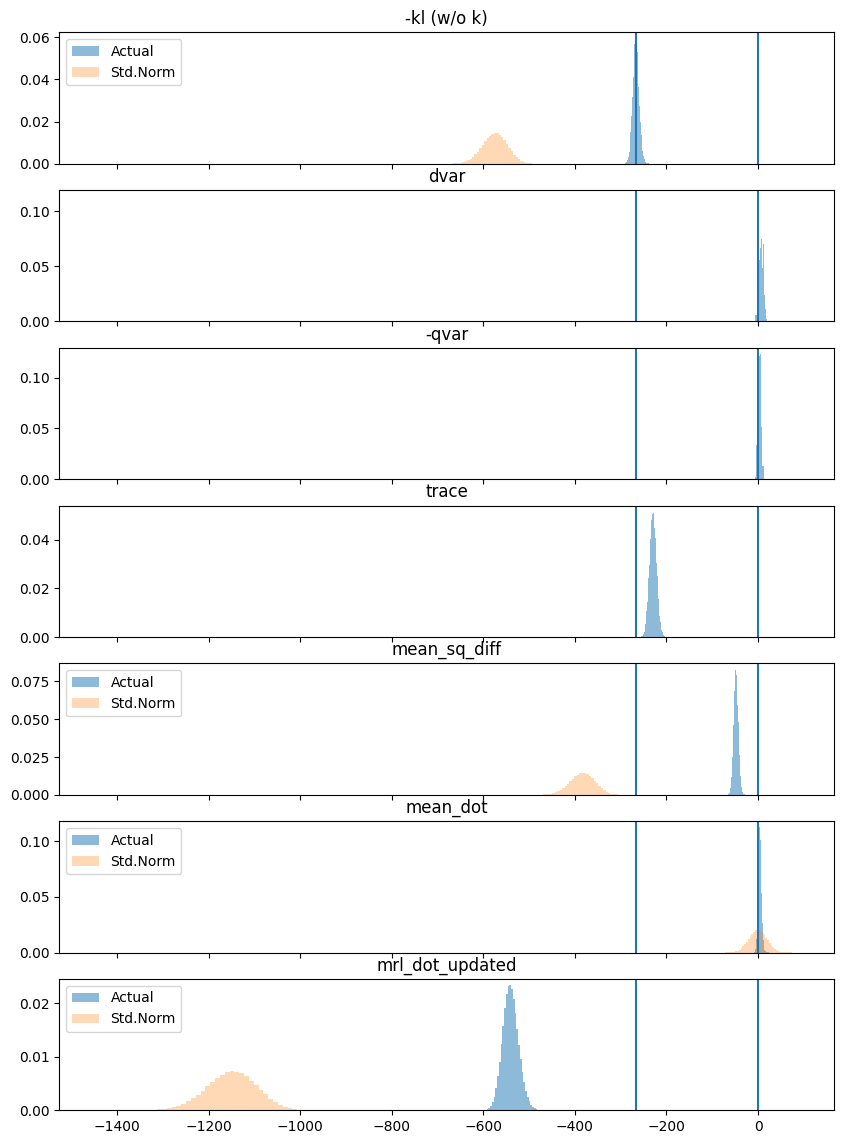

In [86]:
hist_terms(TASB_LV, "msmarco-dev", "msmarco-med-corpus", True, sample_d=1000, sample_p=1000)

-kl (w/o k) -238.39578
dvar 240.48267
-qvar -238.78996
trace -212.98166
mean_sq_diff -27.106855
mean_dot 6.318958
mrl_dot_updated 0.78838646
corr between mean dot product and mean_sq_diff PearsonRResult(statistic=0.5833264877873656, pvalue=0.0)
corr between mean dot product and kl_minus_qvar PearsonRResult(statistic=0.29083264329266206, pvalue=0.0)
corr between mrl_dot product and mean_sq_diff PearsonRResult(statistic=0.7372846907911605, pvalue=0.0)
corr between mrl_dot product and kl_minus_qvar PearsonRResult(statistic=0.8570212261887993, pvalue=0.0)


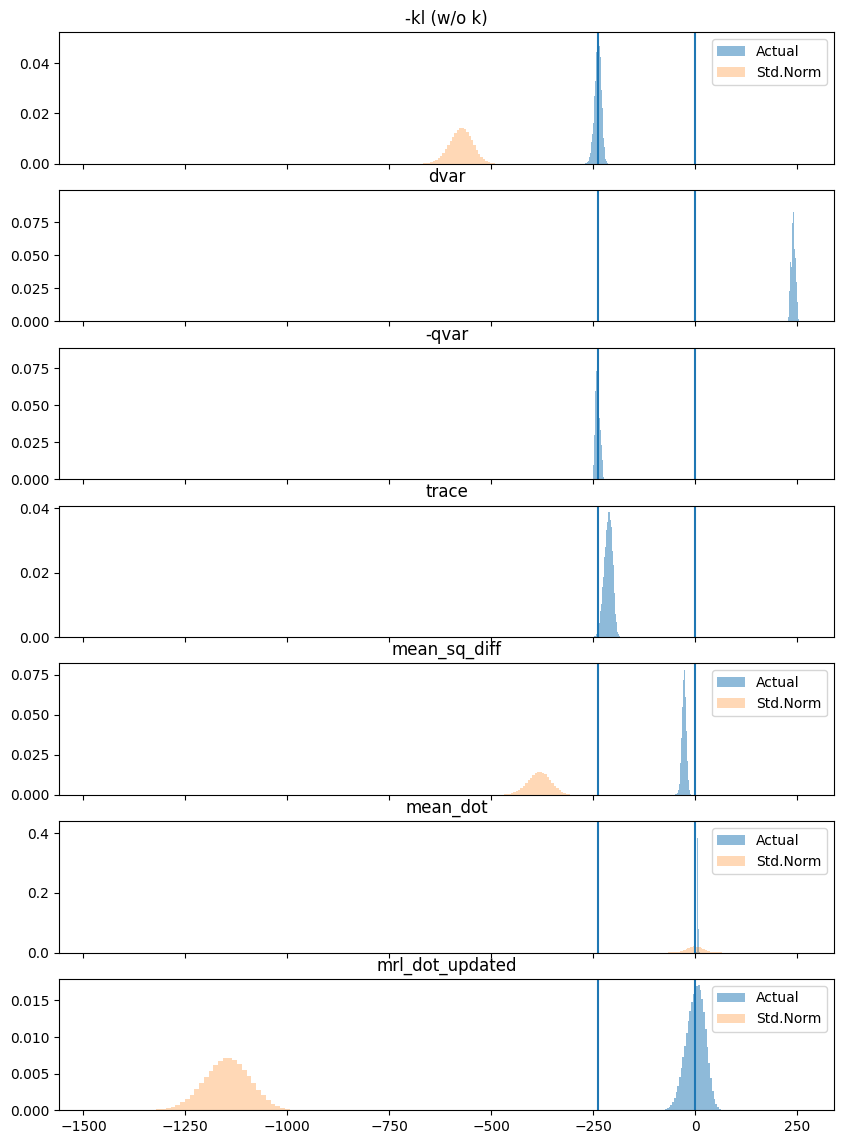

In [87]:
hist_terms(DB, "msmarco-dev", "msmarco-med-corpus", False, sample_d=1000, sample_p=1000)

-kl (w/o k) -251.49748
dvar -1.0968513
-qvar -2.4284077
trace -209.1052
mean_sq_diff -38.867153
mean_dot 8.899937
mrl_dot_updated -498.1385
corr between mean dot product and mean_sq_diff PearsonRResult(statistic=0.7965835683088954, pvalue=0.0)
corr between mean dot product and kl_minus_qvar PearsonRResult(statistic=0.6190582226147302, pvalue=0.0)
corr between mrl_dot product and mean_sq_diff PearsonRResult(statistic=0.8264705873146589, pvalue=0.0)
corr between mrl_dot product and kl_minus_qvar PearsonRResult(statistic=0.8058557971997886, pvalue=0.0)


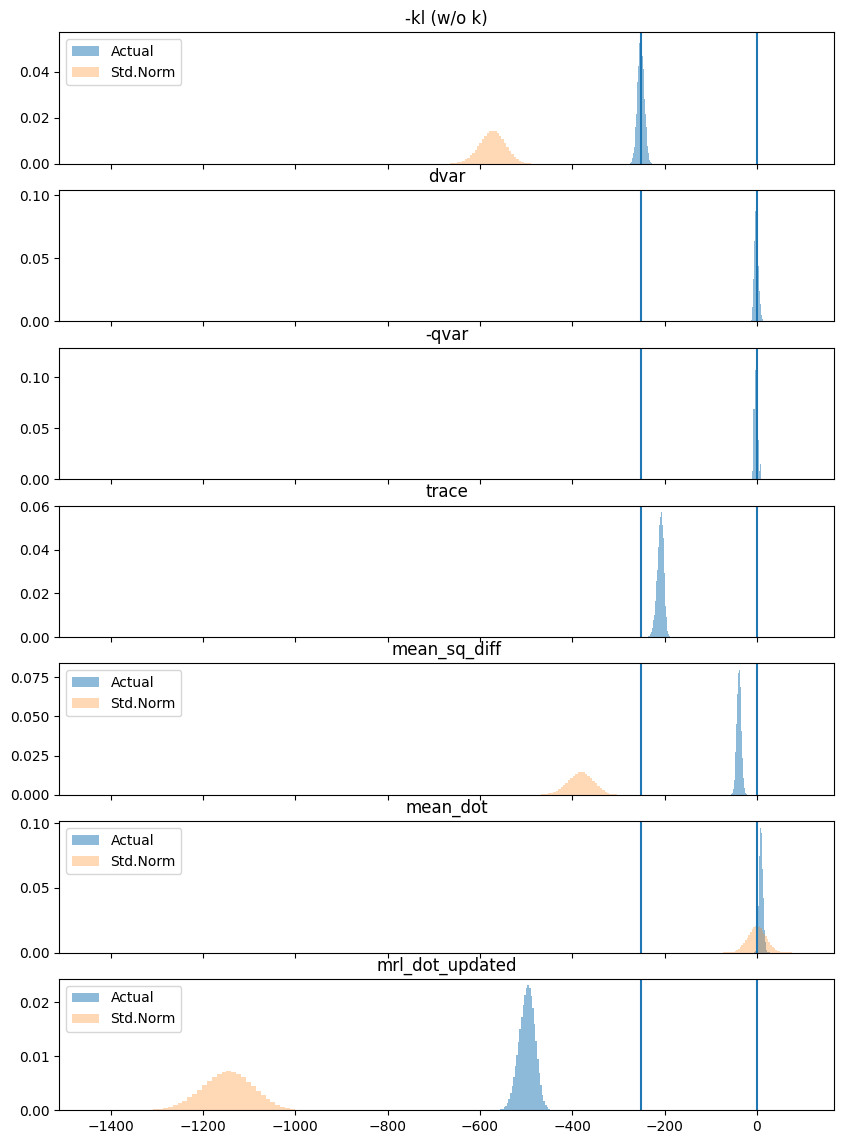

In [88]:
hist_terms(TASB_LV, "dev_scifact", "corpus_scifact", True)

-kl (w/o k) -219.60728
dvar 232.79962
-qvar -235.07323
trace -202.29417
mean_sq_diff -15.0395975
mean_dot 7.710861
mrl_dot_updated 30.931757
corr between mean dot product and mean_sq_diff PearsonRResult(statistic=0.7414358174795974, pvalue=0.0)
corr between mean dot product and kl_minus_qvar PearsonRResult(statistic=0.43262724352825876, pvalue=0.0)
corr between mrl_dot product and mean_sq_diff PearsonRResult(statistic=0.6884158739782361, pvalue=0.0)
corr between mrl_dot product and kl_minus_qvar PearsonRResult(statistic=0.7744433766611722, pvalue=0.0)


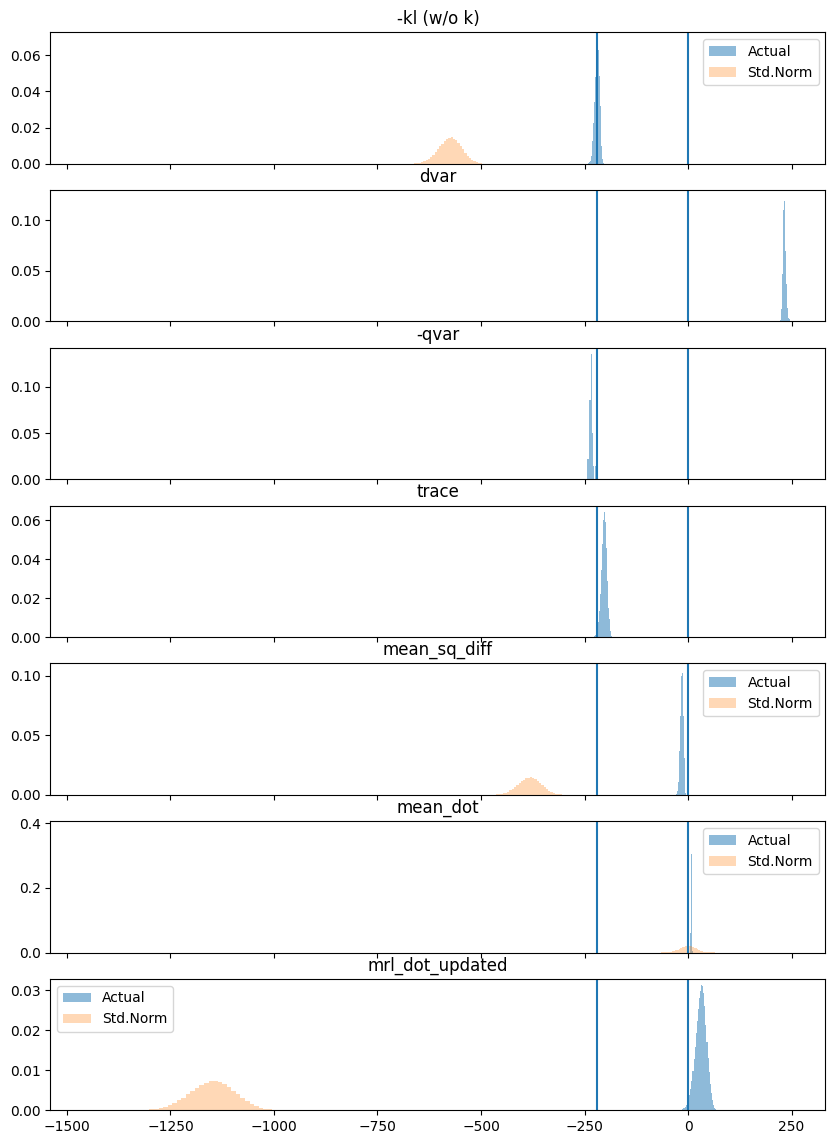

In [89]:
hist_terms(DB, "dev_scifact", "corpus_scifact", False)